In [1]:
import numpy as np
from matplotlib import pyplot as plt
import functools
from ferrari.depressed_cubic_torch import cardan_depressed, stable_cubic
import torch


In [2]:
# def non_linear(x):
#     y = x**3
#     return y

# def inverse_non_linear(y):
#     x = np.sign(y)*np.exp(1/3*np.log(np.abs(y)))
#     return x
    

# Nonlinear Function

In [13]:
def non_linear(x, g):
    y = g*x**3 + (1-g)*x
    return y

def inverse_non_linear(y,g):
    x = stable_cubic((1-g)/g,-y/g)
    return x

def inverse_non_linear_cardan(y,g):
    x = cardan_depressed((1-g)/g,-y/g)
    return x

# Test reverse accuracy

In [26]:
g = torch.rand(100,dtype=torch.float32)
X = torch.linspace(-1,1,100+1,dtype=torch.float32)
err = [] 
err_cardan = []
for x in X:
    y = non_linear(x, g)
    err.append((inverse_non_linear(y,g)-y).numpy())
    err_cardan.append((inverse_non_linear_cardan(y,g)-y).numpy())

err = np.array(err)
err_cardan = np.array(err_cardan)

print("with stable cubic, mean err is:", err.mean(),
      "max err is", err.max(), "\n"
      "with cardan, mean err is:", err_cardan.mean(),
       "max err is", err_cardan.max(),
)


with stable cubic, mean err is: 1.5107712e-09 max err is 0.3814345 
with cardan, mean err is: -1.3143709e-07 max err is 0.38138038


# Multiple Layers

In [27]:
def normalization(x, min, max):
    y = (x - min)*2/(max-min)-1
    return y

def forward_layer(x,a,b,g):
    z = x*a + b
    y = non_linear(z,g) 
    return y


def normalized_forward_layer(x,a,b,c,d,g):
    x = forward_layer(x,a,b,g)
    x = x*c+d
    return x



def forward_function(x,a,b,c,d,g,n_layers):
    for i in range(n_layers):   
        x = normalized_forward_layer(x,a[i],b[i],c[i],d[i],g[i])
    return x



def backward_function(y,a,b,c,d,g,n_layers):
    for i in range(n_layers):
        y = (y-d[n_layers-i-1])/c[n_layers-i-1]
        y = inverse_non_linear(y,g[n_layers-i-1])
        y = (y-b[n_layers-i-1])/a[n_layers-i-1]
    return y


# def normalization(f,x):
#     max = f(1)
#     min = f(0)
#     y = (f(x) - min)/(max-min)
#     return y

In [28]:
n_layers = 20

# a = np.random.rand(n_layers)*2
a = torch.exp(torch.randn(n_layers))
b = a* (np.random.rand(n_layers)*2-1)
g = np.float32(np.random.rand(n_layers))
# g = np.zeros(n_layers)
max = forward_layer(1,a,b,g)
min = forward_layer(-1,a,b,g)
c = 2/(max-min)
d = -min*c-1



In [29]:
forward = functools.partial(forward_function,a=a,b=b,c=c,d=d,g=g,n_layers=n_layers)
backward = functools.partial(backward_function,a=a,b=b,c=c,d=d,g=g,n_layers=n_layers)


/home/wenqingxie/Code/Normalizing-FLow/ferrari/depressed_cardan.py:4: RuntimeWarning: divide by zero encountered in log
  y = np.sign(x)*np.exp(index*np.log(np.abs(x)))
/tmp/ipykernel_1876/2697859287.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


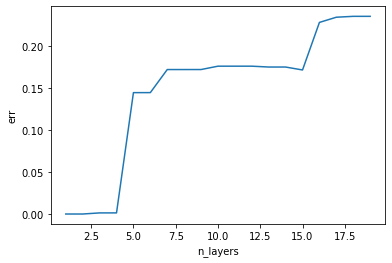

In [57]:
x = np.float32(np.linspace(-1,1,1000+1))
err_list = []
n_layers = np.arange(1,a.shape[0])
for i in n_layers:
    y = forward_function(x,a=a[:i],b=b[:i],c=c[:i],d=d[:i],g=g[:i],n_layers=i)
    x_reverse = backward(y,a=a[:i],b=b[:i],c=c[:i],d=d[:i],g=g[:i],n_layers=i)
    err_list.append(np.max(np.abs(x-x_reverse)))
err = np.array(err_list)

fig,ax = plt.subplots()
ax.plot(n_layers,err)
ax.set_xlabel("n_layers")
ax.set_ylabel("err")
fig.show()

In [30]:
x = np.float32(np.linspace(-1,1,1000+1))
y = forward(x)

gradient = np.gradient(y, x)
x_reverse = backward(y)
err = np.max(np.abs(x-x_reverse))
print(err)

0.7463769


/tmp/ipykernel_30899/2101377656.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


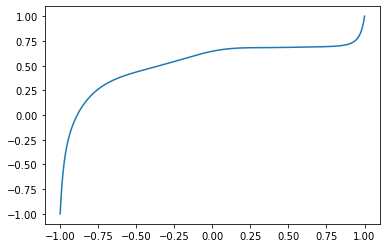

In [276]:
fig,ax = plt.subplots()
ax.plot(x,y)
fig.show()

/tmp/ipykernel_30899/999524737.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


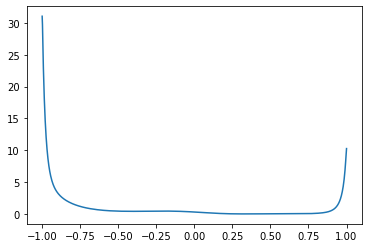

In [277]:
fig,ax = plt.subplots()
ax.plot(x,gradient)
fig.show()

# Add zero points

In [159]:
def find_bias(x0,f):
    y = f(x0)
    return -y

def add_zero_point(x,f,x0):
    b = find_bias(x0,f)
    x = f(x)
    x = x+b
    x = non_linear(x, g=1)
    return x
    
    

In [164]:


x = np.linspace(-1,1,1000+1)
y = add_zero_point(x,forward,x0=-0.6)
gradient = np.gradient(y, x)

/tmp/ipykernel_1906/3438589204.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


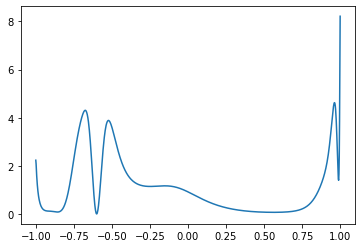

In [165]:
fig,ax = plt.subplots()
ax.plot(x,gradient)
fig.show()



In [55]:
gradient[501]

0.0001629904195993015